In [ ]:
# Install Kaggle
!pip install kaggle

# Make a directory for Kaggle and copy the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

# Download the IMDb dataset
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

# Unzip the downloaded dataset
!unzip imdb-dataset-of-50k-movie-reviews.zip


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 19% 5.00M/25.7M [00:00<00:00, 33.9MB/s]
100% 25.7M/25.7M [00:00<00:00, 113MB/s] 
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('IMDB Dataset.csv')

# Display the first few rows
data.head()



,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from joblib import Parallel, delayed

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply the clean_text function in parallel
data['cleaned_review'] = Parallel(n_jobs=-1)(delayed(clean_text)(text) for text in data['review'])

data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_review'], data['sentiment'], test_size=0.2, random_state=42)

# Convert the labels to numerical format
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create a pipeline with TF-IDF Vectorizer and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('clf', LogisticRegression(max_iter=1000))])

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'tfidf__max_features': [5000, 10000, 20000],
    'clf__C': [0.1, 1, 10]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters found by grid search
best_params = grid_search.best_params_
print(best_params)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'clf__C': 1, 'tfidf__max_features': 20000}


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Detailed classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.8943
Precision: 0.8946081142206022
Recall: 0.8943
F1 Score: 0.894265804900119
              precision    recall  f1-score   support

    negative       0.91      0.88      0.89      4961
    positive       0.88      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
import joblib

# Save the model
joblib.dump(grid_search.best_estimator_, 'sentiment_analysis_model.pkl')

# Save the label encoder
joblib.dump(le, 'label_encoder.pkl')

# Save the evaluation metrics
results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

import json

with open('evaluation_metrics.json', 'w') as f:
    json.dump(results, f)


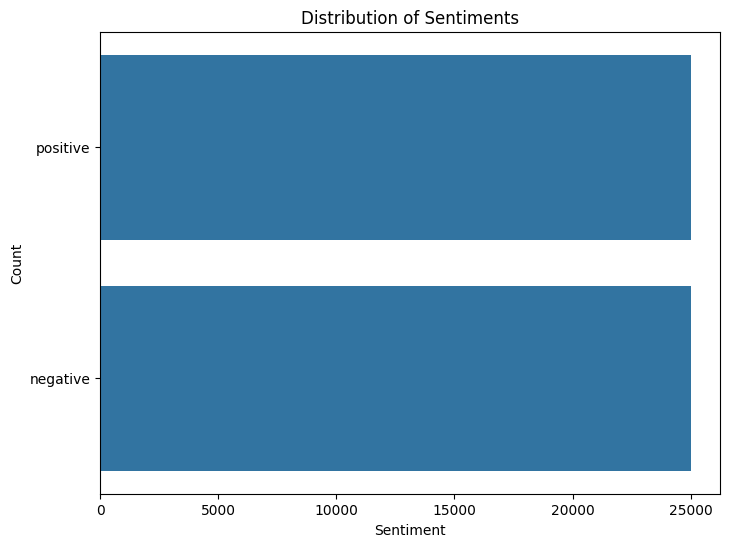

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of sentiments
plt.figure(figsize=(8, 6))
sns.countplot(data['sentiment'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


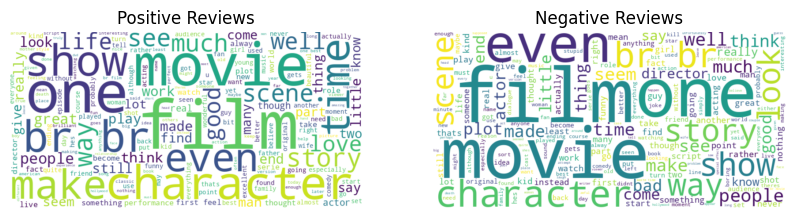

In [ ]:
from wordcloud import WordCloud

# Separate positive and negative reviews
positive_reviews = data[data['sentiment'] == 'positive']['cleaned_review']
negative_reviews = data[data['sentiment'] == 'negative']['cleaned_review']

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))

# Plot word clouds
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis('off')

plt.show()


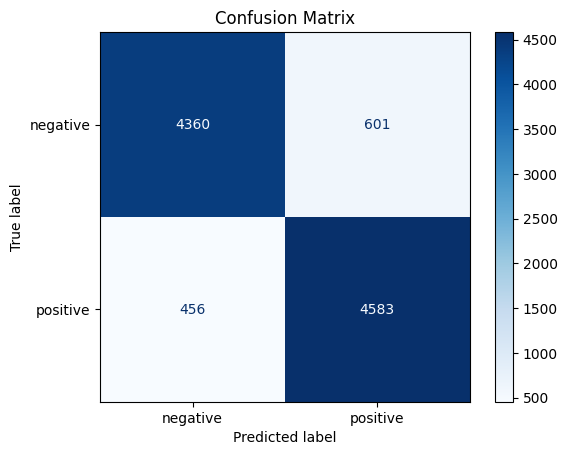

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


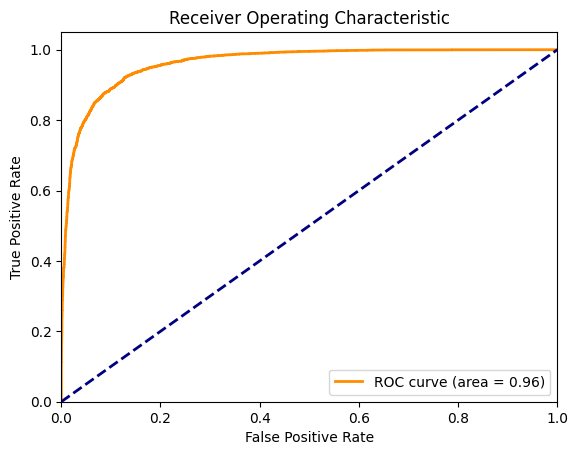

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarize the output
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0, 1])
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


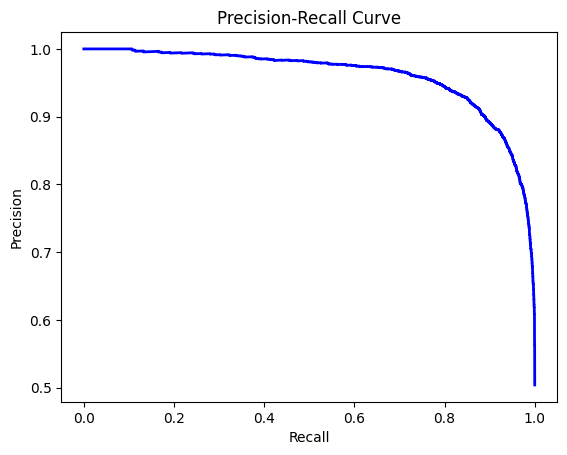

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test_bin, y_pred_proba[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
